# Setup

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd "/content/gdrive/My Drive/Github/SubjectIndexing"

/content/gdrive/My Drive/Github/SubjectIndexing


In [ ]:
# general
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# PCA for plotting 
from sklearn.decomposition import PCA

# classification models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# sklearn utilities
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

# custom library for transformers
from src.utils.embeddings import Book2Vec

# Create Embeddings

In [ ]:
# calculate embeddings module 
# book2vec = Book2Vec(tokenizer='allenai/longformer-base-4096', model='allenai/longformer-base-4096')
# X_embeddings = book2vec.get_embeddings(df.X)
# Book2Vec.save_embeddings(X_embeddings, './work/embeddings_B_last4layers.pkl')

In [ ]:
# import dataset
df = pd.read_json('./data/dataset_B.json')
metadata = pd.read_json('./data/metadata.json')
X_embeddings = Book2Vec.load_embeddings('./work/embeddings_B_last4layers.pkl')
df['X_embeddings'] = list(X_embeddings)
dataset = df[(df['y'] == 'B')|(df['y'] == 'BJ')|(df['y'] == 'BR')]

# Plot Embeddings

In [ ]:
# conduct PCA for graphical representation
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(X_embeddings)
print(pca.explained_variance_ratio_.sum())

0.3827324


In [ ]:
df['2d_x'] = embeddings_2d[:,0]
df['2d_y'] = embeddings_2d[:,1]

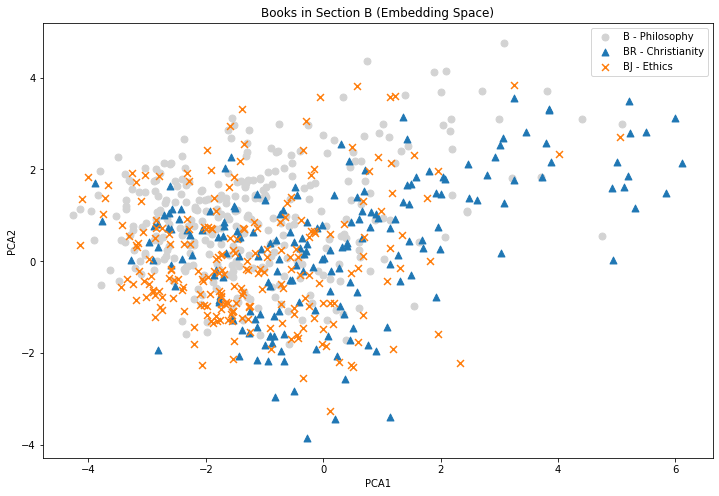

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(df[df['y'] == 'B']['2d_x'], df[df['y'] == 'B']['2d_y'], c='lightgrey', s=48, label='B - Philosophy')
plt.scatter(df[df['y'] == 'BR']['2d_x'], df[df['y'] == 'BR']['2d_y'], c='tab:blue', s=48, marker='^', label='BR - Christianity')
plt.scatter(df[df['y'] == 'BJ']['2d_x'], df[df['y'] == 'BJ']['2d_y'], c='tab:orange', s=48, marker='x', label='BJ - Ethics')
plt.title("Books in Section B (Embedding Space)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
#for i, txt in enumerate([str(x) for x in list(books_B.keys())]):
#    plt.annotate(txt, (embeddings_2d[:,0][i], embeddings_2d[:,1][i]))
plt.legend()
plt.show()

# Classification - All

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    np.stack(df.X_embeddings, axis=0), df.y, test_size=0.2, shuffle=True, random_state=0
)

In [ ]:
labels = sorted(list(set(df.y)))
class2label = {}
for i in range(len(labels)):
    class2label[labels[i]] = i
label2class = {v:k for k,v in class2label.items()}
y_train_labels = [class2label[l] for l in y_train]
y_test_labels = [class2label[l] for l in y_test]

## Random Forest

In [ ]:
# train model
start = time.time()
rf = RandomForestClassifier(n_estimators=512, max_depth=13, random_state=0)
rf_scores = cross_val_score(rf, X_train, y_train_labels, cv=5)
print(np.mean(rf_scores))
end = time.time()
print("Runtime:", round((end-start)//60), "min",  round((end-start)%60), "sec")

0.6023271029690015
Runtime: 4 min 4 sec


In [ ]:
# test accuracy
rf.fit(X_train, y_train_labels)
y_pred = rf.predict(X_test)
accuracy_score(y_test_labels, y_pred)

0.6104252400548696

In [ ]:
y_pred_top3 = np.argpartition(rf.predict_proba(X_test), -3)[:,-3:]
accuracy_score_top3 = []
for i in range(len(y_test_labels)):
    if y_test_labels[i] in y_pred_top3[i]:
        accuracy_score_top3.append(1)
    else:
        accuracy_score_top3.append(0)
np.mean(accuracy_score_top3)

0.8367626886145405

## XGBoost

In [ ]:
# start = time.time()
# xgb = XGBClassifier(max_depth=5)
# xgb_scores = cross_val_score(xgb, X_train, y_train, cv=5)
# print(12, np.mean(xgb_scores))
# end = time.time()
# print("Runtime:", round((end-start)//60), "min",  round((end-start)%60), "sec")

In [ ]:
# xgb.fit(X_train, y_train_labels)
# y_pred = xgb.predict(X_test)
# accuracy_score(y_test_labels, y_pred)

## SVM

In [ ]:
# train svm
start = time.time()
svm = make_pipeline(StandardScaler(), SVC(C=10, gamma='scale', random_state=0))
svm_scores = cross_val_score(svm, X_train, y_train_labels, cv=5)
print(np.mean(svm_scores))
end = time.time()
print("Runtime:", round((end-start)//60), "min",  round((end-start)%60), "sec")

0.6641468173271324
Runtime: 3 min 2 sec


In [ ]:
# test accuracy
svm = make_pipeline(StandardScaler(), SVC(C=10, gamma='scale', random_state=0))
svm.fit(X_train, y_train_labels)
y_pred = svm.predict(X_test)
accuracy_score(y_test_labels, y_pred)

0.663923182441701

In [ ]:
y_pred_top3 = np.argpartition(svm.decision_function(X_test), -3)[:,-3:]
accuracy_score_top3 = []
for i in range(len(y_test_labels)):
    if y_test_labels[i] in y_pred_top3[i]:
        accuracy_score_top3.append(1)
    else:
        accuracy_score_top3.append(0)
np.mean(accuracy_score_top3)

0.8683127572016461

Text(0.5, 1.0, 'Confusion Matrix')

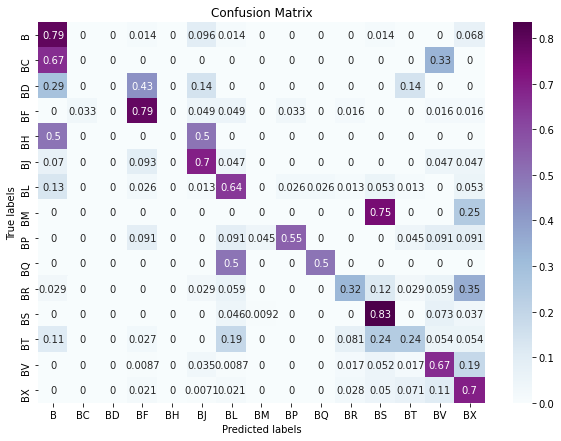

In [ ]:
cm = confusion_matrix(y_true=y_test_labels, y_pred=y_pred, labels=list(class2label.values()), normalize='true')
cm_df = pd.DataFrame(cm, index=[i for i in labels], columns=[i for i in labels])
plt.figure(figsize = (10,7))
ax = plt.subplot()
sn.heatmap(cm_df, annot=True, cmap='BuPu', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

## Neural Net

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# model structure
input = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(1024, activation='relu')(input)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output = tf.keras.layers.Dense(len(set(labels)), activation='softmax')(x)
model = tf.keras.Model(inputs=input, outputs=output)

# compile model
model.compile(
    loss = 'sparse_categorical_crossentropy', 
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics = ['sparse_categorical_accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 15)                1935      
Total params: 3,279,887
Trainable params: 3,279,887
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model
history = model.fit(
    X_train, tf.convert_to_tensor(y_train_labels), validation_split=0.2, shuffle=True,
    batch_size=256, epochs=300, verbose=0,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)]
)

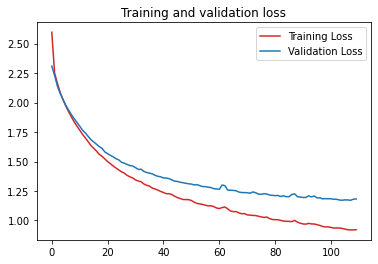

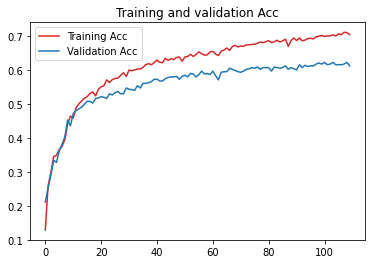

In [ ]:
# print training history
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'tab:red', label='Training Loss')
plt.plot(epochs, val_loss, 'tab:blue', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'tab:red', label='Training Acc')
plt.plot(epochs, val_acc, 'tab:blue', label='Validation Acc')
plt.title('Training and validation Acc')
plt.legend()
plt.show()

In [ ]:
# test accuracy 
y_test_labels = [class2label[l] for l in y_test]
y_pred = model.predict(X_test, batch_size=256, verbose=0)
y_pred_top1 =  np.argmax(y_pred, axis=-1)
accuracy_score(y_test_labels, y_pred_top1)

0.6296296296296297

In [ ]:
y_pred_top3 = np.argpartition(y_pred, -3)[:,-3:]
accuracy_score_top3 = []
for i in range(len(y_test_labels)):
    if y_test_labels[i] in y_pred_top3[i]:
        accuracy_score_top3.append(1)
    else:
        accuracy_score_top3.append(0)
np.mean(accuracy_score_top3)

0.8765432098765432

Text(0.5, 1.0, 'Confusion Matrix')

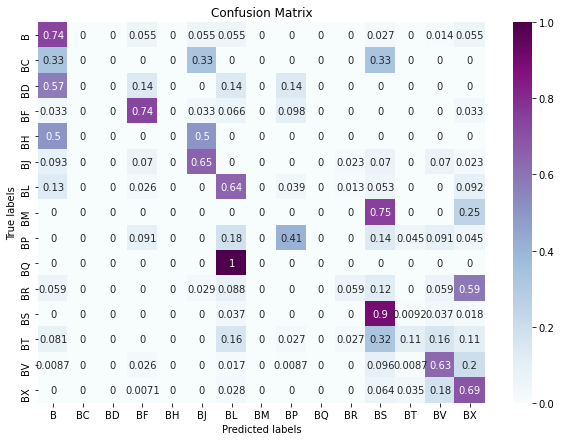

In [ ]:
cm = confusion_matrix(y_true=y_test_labels, y_pred=y_pred_top1, labels=list(class2label.values()), normalize='true')
cm_df = pd.DataFrame(cm, index=[i for i in labels], columns=[i for i in labels])
plt.figure(figsize = (10,7))
ax = plt.subplot()
sn.heatmap(cm_df, annot=True, cmap='BuPu', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Classification - B, BJ, BR

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    np.stack(dataset.X_embeddings, axis=0), dataset.y, test_size=0.2, shuffle=True, random_state=0
)

In [ ]:
labels = sorted(list(set(dataset.y)))
class2label = {}
for i in range(len(labels)):
    class2label[labels[i]] = i
label2class = {v:k for k,v in class2label.items()}
y_train_labels = [class2label[l] for l in y_train]
y_test_labels = [class2label[l] for l in y_test]

## Random Forest

In [ ]:
# train model
start = time.time()
rf = RandomForestClassifier(n_estimators=512, max_depth=13, random_state=0)
rf_scores = cross_val_score(rf, X_train, y_train_labels, cv=5)
print(np.mean(rf_scores))
end = time.time()
print("Runtime:", round((end-start)//60), "min",  round((end-start)%60), "sec")

0.8212791040377247
Runtime: 0 min 26 sec


In [ ]:
# test accuracy
rf.fit(X_train, y_train_labels)
y_pred = rf.predict(X_test)
accuracy_score(y_test_labels, y_pred)

0.8356164383561644

In [ ]:
y_pred_top3 = np.argpartition(rf.predict_proba(X_test), -3)[:,-3:]
accuracy_score_top3 = []
for i in range(len(y_test_labels)):
    if y_test_labels[i] in y_pred_top3[i]:
        accuracy_score_top3.append(1)
    else:
        accuracy_score_top3.append(0)
np.mean(accuracy_score_top3)

1.0

## XGBoost

In [ ]:
# start = time.time()
# xgb = XGBClassifier(max_depth=5)
# xgb_scores = cross_val_score(xgb, X_train, y_train, cv=5)
# print(12, np.mean(xgb_scores))
# end = time.time()
# print("Runtime:", round((end-start)//60), "min",  round((end-start)%60), "sec")

In [ ]:
# xgb.fit(X_train, y_train_labels)
# y_pred = xgb.predict(X_test)
# accuracy_score(y_test_labels, y_pred)

## SVM

In [ ]:
# train svm
start = time.time()
svm = make_pipeline(StandardScaler(), SVC(C=10, gamma='scale', random_state=0))
svm_scores = cross_val_score(svm, X_train, y_train_labels, cv=5)
print(np.mean(svm_scores))
end = time.time()
print("Runtime:", round((end-start)//60), "min",  round((end-start)%60), "sec")

0.8590627763041556
Runtime: 0 min 7 sec


In [ ]:
# test accuracy
svm = make_pipeline(StandardScaler(), SVC(C=10, gamma='scale', random_state=0))
svm.fit(X_train, y_train_labels)
y_pred = svm.predict(X_test)
accuracy_score(y_test_labels, y_pred)

0.8698630136986302

In [ ]:
y_pred_top3 = np.argpartition(svm.decision_function(X_test), -3)[:,-3:]
accuracy_score_top3 = []
for i in range(len(y_test_labels)):
    if y_test_labels[i] in y_pred_top3[i]:
        accuracy_score_top3.append(1)
    else:
        accuracy_score_top3.append(0)
np.mean(accuracy_score_top3)

1.0

Text(0.5, 1.0, 'Confusion Matrix')

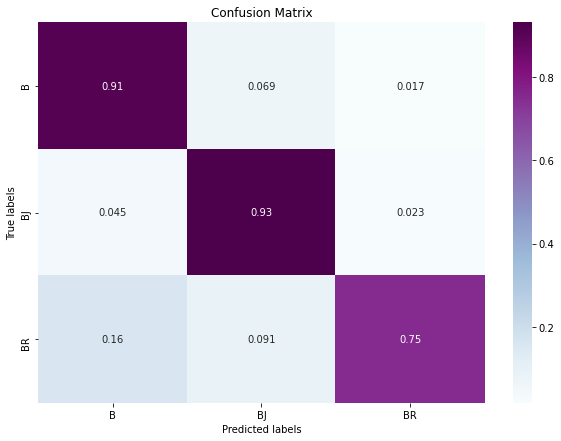

In [ ]:
cm = confusion_matrix(y_true=y_test_labels, y_pred=y_pred, labels=list(class2label.values()), normalize='true')
cm_df = pd.DataFrame(cm, index=[i for i in labels], columns=[i for i in labels])
plt.figure(figsize = (10,7))
ax = plt.subplot()
sn.heatmap(cm_df, annot=True, cmap='BuPu', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

## Neural Net

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# model structure
input = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(1024, activation='relu')(input)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(len(set(labels)), activation='softmax')(x)
model = tf.keras.Model(inputs=input, outputs=output)

# compile model
model.compile(
    loss = 'sparse_categorical_crossentropy', 
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics = ['sparse_categorical_accuracy']
)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dense_4 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 3,212,547
Trainable params: 3,212,547
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model
history = model.fit(
    X_train, tf.convert_to_tensor(y_train_labels), validation_split=0.2, shuffle=True,
    batch_size=256, epochs=300, verbose=0,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)]
)

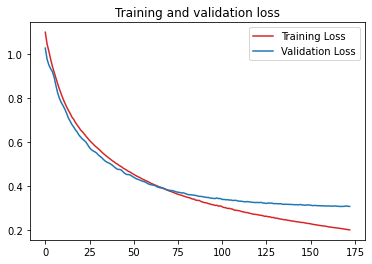

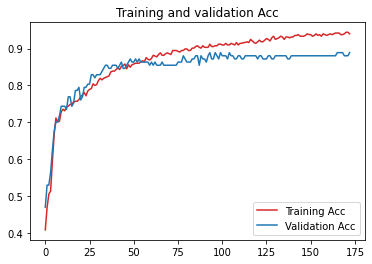

In [ ]:
# print training history
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'tab:red', label='Training Loss')
plt.plot(epochs, val_loss, 'tab:blue', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'tab:red', label='Training Acc')
plt.plot(epochs, val_acc, 'tab:blue', label='Validation Acc')
plt.title('Training and validation Acc')
plt.legend()
plt.show()

In [ ]:
# test accuracy 
y_test_labels = [class2label[l] for l in y_test]
y_pred = model.predict(X_test, batch_size=256, verbose=0)
y_pred_top1 =  np.argmax(y_pred, axis=-1)
print(accuracy_score(y_test_labels, y_pred_top1))

0.8904109589041096


In [ ]:
y_pred_top3 = np.argpartition(y_pred, -3)[:,-3:]
accuracy_score_top3 = []
for i in range(len(y_test_labels)):
    if y_test_labels[i] in y_pred_top3[i]:
        accuracy_score_top3.append(1)
    else:
        accuracy_score_top3.append(0)
np.mean(accuracy_score_top3)

1.0

Text(0.5, 1.0, 'Confusion Matrix')

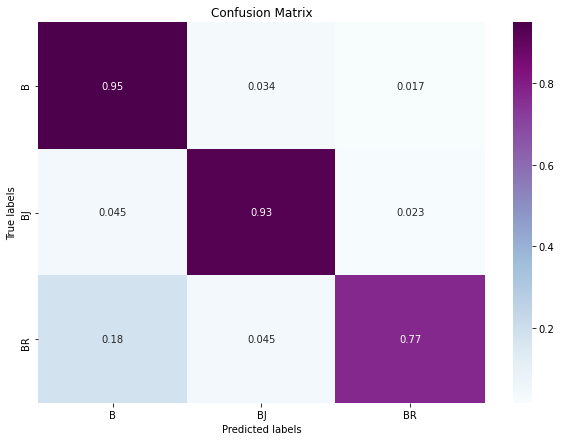

In [ ]:
cm = confusion_matrix(y_true=y_test_labels, y_pred=y_pred_top1, labels=list(class2label.values()), normalize='true')
cm_df = pd.DataFrame(cm, index=[i for i in labels], columns=[i for i in labels])
plt.figure(figsize = (10,7))
ax = plt.subplot()
sn.heatmap(cm_df, annot=True, cmap='BuPu', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')